# **Simple Scenario Example - Charleston, USA**

In this notebook we demonstrate the **workflow** on how you can build a simple **FloodAdapt scenario** in Charleston, USA, using the **API**.  

We prepared a database, which you can download from [**here**](link.com). If you worked with the [**Database-Builder notebook**](database_builder.ipynb) beforehand, you can use that database.


In this notebook we will cover the following steps:

1. Create a synthetic **event** 
2. Create a **projection** - Sea level rise (SLR)
3. Create a **measure** and **strategy** - Seawall
4. Create and run a **scenario**
6. Investigate the **output**


## **Step 0**: Import packages

In [1]:
# Import packages
from datetime import datetime
from pathlib import Path

from flood_adapt.config.sfincs import RiverModel
from flood_adapt.dbs_classes.database import Database
from flood_adapt.objects.events.synthetic import SyntheticEvent 
from flood_adapt.objects.forcing.discharge import DischargeConstant
from flood_adapt.objects.forcing.forcing import ForcingType
from flood_adapt.flood_adapt import FloodAdapt
from flood_adapt.objects.forcing.forcing import (
    ForcingSource,
    ForcingType,)
from flood_adapt.objects.forcing.rainfall import RainfallConstant
from flood_adapt.objects.forcing.time_frame import (
    TimeFrame,
)
from flood_adapt.objects.forcing.timeseries import (
    ShapeType,
    TimeseriesFactory,
)
from flood_adapt.objects.forcing.waterlevels import (
    SurgeModel,
    TideModel,
    WaterlevelSynthetic,
)
from flood_adapt.objects.forcing.wind import WindConstant
from flood_adapt.objects.measures.measures import (
    Elevate,
    FloodWall,
    Measure,
    MeasureType,
    SelectionType,
    HazardMeasure
)
from flood_adapt.objects.projections.projections import Projection, PhysicalProjection, SocioEconomicChange
from flood_adapt.objects.scenarios.scenarios import Scenario
from flood_adapt import Settings
from flood_adapt.objects.strategies.strategies import Strategy
from flood_adapt import unit_system as us

## **Step 1**: Getting started - Initiate the database

Let's start with initiating the database and FloodAdapt class. 
1. Define the **path** to your database
2. Initiate the database **"Settings"-class** by defining the **database root** and **name**
3. Initiate the **FloodAdapt instance** by parsing the Settings().database_path

In [2]:
# Define the full path to your database file
full_path = Path(r"C:\Users\rautenba\Local_FA_Databases\Database\charleston_full")

# Set up the settings for the database
Settings(DATABASE_ROOT=full_path.parent, DATABASE_NAME=full_path.name)

# Create the FloodAdapt instance
fa = FloodAdapt(Settings().database_path)

## **Step 2**: Events - Create a synthetic Event

Events in FloodAdapt are categorized into different forcings:
1. Wind
2. Rainfall
3. Discharge
4. Water Level 

If you want to learn more about the individual forcings in FloodAdapt, please go and read the section on [**Events**](https://deltares-research.github.io/FloodAdapt/4_user_guide/events/) in the FloodAdapt documentation.

When creating an event we need to create an **Event object** with the following inputs:
1. ***name***: The name of the event
2. ***description*** (optional): The description of the event
3. ***time***: An object that captures the start_time and end_time
4. ***forcings***: A dictionary the collects the objects for each forcing.
 
    In this event example we will create an event with the following forcings:
    - **constant** wind: Define a value for a constant wind speed (mps) and direction (degrees)
    - **constant** rainfall: Define a value for a constant rainfall (mm/hr)
    - **constant** discharge: Define the x and y coordinates of the discharge point of the Cooper River and a value for a constant mean discharge (cfs) in the River- and Discharge model (same value)
    - **synthetic water level (surge)**: Define a peak time (h), peak value in (m) and duration (d)
    - **synthetic water level (harmonic tide)**: Define the harmonic amplitude (m), harmonic period (h) and harmonic phase (h) 

For a complete guide on all the possible event inputs and options check out the notebook [**eventblablab**](nolink).

In [3]:
# Create a synthetic event object
attrs_event = SyntheticEvent(
        name="synthetic_nearshore",
        description = "This is a synthetic nearshore event",
        time=TimeFrame(
            start_time=datetime(2020, 1, 1),
            end_time=datetime(2020, 1, 2),
        ),
        forcings={
            ForcingType.WIND: [
                WindConstant(
                    speed=us.UnitfulVelocity(value=5, units=us.UnitTypesVelocity.mps),
                    direction=us.UnitfulDirection(
                        value=60, units=us.UnitTypesDirection.degrees
                    ),
                )
            ],
            ForcingType.RAINFALL: [
                RainfallConstant(
                    intensity=us.UnitfulIntensity(
                        value=20, units=us.UnitTypesIntensity.mm_hr
                    )
                )
            ],
            ForcingType.DISCHARGE: [
                DischargeConstant(
                    river=RiverModel(
                        name="cooper",
                        description="Cooper River",
                        x_coordinate=595546.3,
                        y_coordinate=3675590.6,
                        mean_discharge=us.UnitfulDischarge(
                            value=5000, units=us.UnitTypesDischarge.cfs
                        ),
                    ),
                    discharge=us.UnitfulDischarge(
                        value=5000, units=us.UnitTypesDischarge.cfs
                    ),
                )
            ],
            ForcingType.WATERLEVEL: [
                WaterlevelSynthetic(
                    surge=SurgeModel(
                        timeseries=TimeseriesFactory.from_args(
                            shape_type=ShapeType.triangle,
                            duration=us.UnitfulTime(
                                value=1, units=us.UnitTypesTime.days
                            ),
                            peak_time=us.UnitfulTime(
                                value=8, units=us.UnitTypesTime.hours
                            ),
                            peak_value=us.UnitfulLength(
                                value=1, units=us.UnitTypesLength.meters
                            ),
                        )
                    ),
                    tide=TideModel(
                        harmonic_amplitude=us.UnitfulLength(
                            value=1, units=us.UnitTypesLength.meters
                        ),
                        harmonic_period=us.UnitfulTime(
                            value=12.4, units=us.UnitTypesTime.hours
                        ),
                        harmonic_phase=us.UnitfulTime(
                            value=0, units=us.UnitTypesTime.hours
                        ),
                    ),
                )
            ],
        },
    )

#### You created your first event object!
After creating the **event object**, we can use the API to **create** and **save** the event in the database. 

*Note! An event can only be created <u>once</u> under a specific name and won't be overwritten, if you try to save another event under the same name.* 

In [4]:
# Create the event
fa.create_event(attrs_event.model_dump(exclude_none=True))

# Save the event to the database
fa.save_event(attrs_event)

## **Step 3**: Projections - Create a projection

**Projections** in FloodAdapt allow us to adjust our model to future conditions such as sea level rise or/and population growth. If you want to learn more about projections in FlooAdapt please go to the section ["Projections"](https://deltares-research.github.io/FloodAdapt/4_user_guide/projections/) in the FloodAdapt documentation. 

In this example we will create a sea level rise (SLR) projection of 2ft.  
The projections can be divided into two categories:
1. **Physical Projections**: Sea level rise, intensified precipitation, increased storm frequency
2. **Socio economic change**: Population growth (existing built area, new development area), economic growth

When creating a projection we need to create a **Projection object** with the following inputs:
1. ***name***: The name of the projection
2. ***description*** (optional): The description of the projection
3. ***physical projection***: An object that captures the pysical projection.
    In this example we will create the following physical projections:
    - Sea level rise: Define the value of the sea level rise and the unit (m, ft)
    - Subsidence: Define the value of the subsidence and the unit (m,ft)
4. ***socio economic change***: An object that captures the socio economic change.
    In this example we will create the following socio economic projections:
    - None: Leave the object empty

To get a deeper understanding for all the possible projections and their inputs go to the notebook [**projectionblablab**](nolink).


In [5]:
# Create a projection object
attrs_projection = Projection(
    name="SLR_2ft",
    description = "This is a 2ft SLR projection",
    physical_projection=PhysicalProjection(
        sea_level_rise=us.UnitfulLength(value=2, units=us.UnitTypesLength.feet),
        subsidence=us.UnitfulLength(value=1, units=us.UnitTypesLength.feet),
    ),
    socio_economic_change=SocioEconomicChange(),
)

#### You created your first projection object!
After creating the **projection object**, we can use the API to **create** and **save** the projection in the database. 

*Note! A projection can only be created <u>once</u> under a specific name and won't be overwritten, if you try to save another projection under the same name.* 

In [6]:
# Create the projection
fa.create_projection(attrs_projection.model_dump(exclude_none=True))

# Save the projection
fa.save_projection(attrs_projection)

## **Step 4**: Measures - Create a measure

**Measures** in FloodAdapt enable the user to investigate the efficiency of these mitigation measures on the spot. Measures can be hydraulic, green infrastructure or be on the building level. You can read more about measures in the section ["Measures"](https://deltares-research.github.io/FloodAdapt/4_user_guide/measures/) in the FloodAdapt documentation. 

In this example we will create a **hydraulic measure**, a sea wall of 12ft.  
When creating a sea wall as measure we need to create a **Measure object** with the following inputs:
1. ***name***: The name of the measure
2. ***description*** (optional): The description of the measure
3. ***type***: The type of the measure. In this example a floodwall object. 
4. ***selection type***: The type of shape. In this example we define a polyline for the shape of the seawall 
5. ***polygon file***: The file path to the spatial file of the seawall
6. ***elevation***: The elevation of the sea wall. Define a value and the unit (ft,m)


In [7]:
# Create a measure object
attrs_measure_phy = FloodWall(
        name= "Seawall_12ft",
        description = "12ft Seawall",
        type = MeasureType.floodwall,
        selection_type = SelectionType.polyline,
        polygon_file = str(r"C:\Users\rautenba\repos\Database\charleston_full\input\measures\seawall\seawall.geojson"),
        elevation = us.UnitfulLength(value=12, units=us.UnitTypesLength.feet))

#### You created your first measure object!
After creating the **measure object**, we can use the API to **create** and **save** the measure in the database. 

*Note! A measure can only be created <u>once</u> under a specific name and won't be overwritten, if you try to save another measure under the same name.* 

In [8]:
# Create the measure
fa.create_measure(attrs_measure_phy.model_dump(exclude_none=True), type=attrs_measure_phy.type)

# Save the measure
fa.save_measure(attrs_measure_phy)

Let's add another measure on the **building level**. We can elevate buildings in a specific area to mititgate the impact on these assets.

When elevating biuldings as measure we need to create a **Measure object** with the following inputs:
1. ***name***: The name of the measure
2. ***description*** (optional): The description of the measure
3. ***type***: The type of the measure. In this example an Elevate object. 
4. ***selection type***: The type of shape. In this example we define a polygone for selecting the area of affected buildings 
5. ***polygon file***: The file path to the spatial file of the to be elevated area
6. ***property type***: The type of building that sholud be elevated. Define the building type (residnetial, commercial...) of your Fiat Model you wish to elevate. In this example we want to elevate all buildings.
7. ***elevation***: The elevation of the buildings. Define a value, the unit (ft,m) and the vertical reference for the elevation (datum, floodmap). 

In [9]:
# Create a measure object
attrs_measure_elev = Elevate(
        name= "Elevated_homes",
        description = "Elevate residential buildings",
        type = MeasureType.elevate_properties,
        selection_type = SelectionType.polygon,
        polygon_file = str(r"C:\Users\rautenba\repos\Database\charleston_full\input\measures\raise_property_polygon\raise_property_polygon.geojson"),
        property_type = "ALL",
        elevation = us.UnitfulLengthRefValue(value=1, units=us.UnitTypesLength.feet, type = us.VerticalReference.floodmap))

# Create the measure
fa.create_measure(attrs_measure_elev.model_dump(exclude_none=True), type=attrs_measure_elev.type)

# Save the measure
fa.save_measure(attrs_measure_elev)

## **Step 5**: Strategies - Create a strategy

**Strategies** in FloodAdapt are a combination of measures. When we compile multiple measures in a strategy, we first have to create all te measures we would like to use. Find out more about strategies in the section ["Strategies"](https://deltares-research.github.io/FloodAdapt/4_user_guide/strategy/) in the FloodAdapt documentation. 

In this example we will create a strategy with the measures we created above, a **sea wall** of 12ft and **elevating homes** 1ft above the floodmap reference in a specific area.  
When creating a strategy we need to create a **Strategy object** with the following inputs:
1. ***name***: The name of the strategy
2. ***description*** (optional): The description of the strategy
3. ***measures***: A list of all the measure object names, you would like to use in that strategy. 

In [10]:
# Create a strategy object
attrs_strategy = Strategy(
        name= "seawall_and_new_develpoment_area",
        description = "Strategy with a seawall and a new development area",
        measures = [attrs_measure_phy.name, attrs_measure_elev.name],
        )

#### You created your first strategy object!
After creating the **strategy object**, we can use the API to **create** and **save** the strategy in the database. 

*Note! A strategy can only be created <u>once</u> under a specific name and won't be overwritten, if you try to save another strategy under the same name.* 

In [11]:
# Create the stategy
fa.create_strategy(attrs_strategy .model_dump(exclude_none=True))

# Save the stategy
fa.save_strategy(attrs_strategy )

## **Step 6**: Create a scenario

We reached the final step where we can put all the building blocks together to create a complete scenario!  
A scenario is composed of:

**1. Event**  
**2. Projection**  
**3. Strategy (Measures)**

If you want to read more about the composition of scenarios, go read the [**Scenario**](https://deltares-research.github.io/FloodAdapt/4_user_guide/scenarios/)-section of the FloodAdapt documentation. 

In this example we will create a scenario with the event, projection and strategy we created above. 
When creating a scenario we need to create a **Scenario object** with the following inputs:
1. ***name***: The name of the strategy
2. ***description*** (optional): The description of the scenario
3. ***event***: The name of the event object 
3. ***projection***: The name of the projection object 
3. ***strategy***: The name of the strategy object 

In [12]:
# Create a scenario object
scenario = Scenario(
    name = "slr_nearshore_seawall_elev_build",
    description = "Nearshore event with SLR projection and seawall + elevated buildings strategy",
    event =  attrs_event.name,
    projection =  attrs_projection.name,
    strategy = attrs_strategy.name,
)

#### You created your first scenario object!
After creating the **scenario object**, we can use the API to **create** and **save** the scenario in the database. 

*Note! A scenario can only be created <u>once</u> under a specific name and won't be overwritten, if you try to save another scenario under the same name.* 

In [13]:
# Create the scenario
fa.create_scenario(scenario.model_dump())

# Save the scenario
fa.save_scenario(scenario)

(True, '')

## **Final step**: Run a scenario

We are ready to **run** the scenario! Simply use the **API** to run the scenario.

In [14]:
# Run the scenario
fa.run_scenario(scenario.name)

2025-05-08 11:35:48 AM - FloodAdapt.SfincsAdapter - WARNING - Failed to add event rainfall multiplier, no rainfall forcing found in the model.
2025-05-08 11:35:49 AM - FloodAdapt.SfincsAdapter - WARNING - Could not use height data from file due to missing `z` column or missing values therein. Using uniform height of 12.0 feet instead.


### **DONE!** 
**Congratulations** you created and ran your first FloodAdapt scenario!

## **Output**: Let's inspect the output

#### 1. Output files
In your scenario output folder you should see the following files:
- **Flooding**: Folder
- **Impacts**: Folder
- **finished.txt**: text file
- **Infometrics_"*scenario_name*".csv**: csv file of the overall infometrics
- **Infometrics_"*scenario_name*"_"*aggregation_layer*".csv**: csv file  of the aggregated areas. You have one file per aggregation level. In this example we have two files. 
- **logfile_"*scenario_name*".log**: The log of the scenario run
- **"*scenario_name*"_metrics.html**: A metric file of your scenario output

The figure below presents a visual overview of all the output files that should be in your database after running the scenario
<div>
<img src="../_static/images/output_folder_event.png" width="500"/>
</div>

#### 2. Floodmap

We can open and inspect the floodmap geotiff.

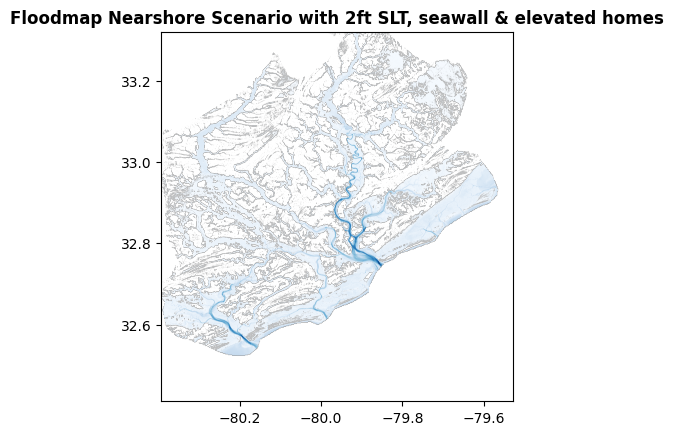

<Axes: title={'center': 'Floodmap Nearshore Scenario with 2ft SLT, seawall & elevated homes'}>

In [ ]:
import rasterio
import rasterio.plot

# Open floodmap geotiff
data_name = r"C:\Users\rautenba\Local_FA_Databases\Database\charleston_full\output\scenarios\slr_nearshore_seawall_elev_build\Flooding\FloodMap_slr_nearshore_seawall_elev_build.tif"
tiff = rasterio.open(data_name)

# Plot floodmap
rasterio.plot.show(tiff, title = "Floodmap nearshore scenario with 2ft SLR, seawall & elevated buildings", cmap="Blues")

#### 3. Economic Impacts

We can plot the economic impacts on the building level and on the aggregated level.

In [ ]:
import geopandas as gpd
import contextily as cx
# Open building impacts
gdf_impacts_buildings = gpd.read_file(r"C:\Users\rautenba\Local_FA_Databases\Database\charleston_full\output\scenarios\slr_nearshore_seawall_elev_build\Impacts\Impacts_building_footprints_slr_nearshore_seawall_elev_build.gpkg")

# Plot building impacts
ax = gdf_impacts_buildings.plot(column = "Total Damage",cmap="Reds", legend = True, vmax= 70000, legend_kwds={"label": "Total Damages ($) Buildings", "orientation": "horizontal"})
cx.add_basemap(ax)

# Open aggregated impacts
gdf_impacts_aggr = gpd.read_file(r"C:\Users\rautenba\Local_FA_Databases\Database\charleston_full\output\scenarios\slr_nearshore_seawall_elev_build\Impacts\Impacts_aggregated_slr_nearshore_seawall_elev_build_aggr_lvl_2.gpkg")

# Plot aggregated impacts
ax = gdf_impacts_aggr.plot(column = "Total Damage",cmap="Reds", legend = True, vmax= 70000, legend_kwds={"label": "Total Damages ($) per aggregatetion area", "orientation": "horizontal"})
cx.add_basemap(ax)

ModuleNotFoundError: No module named 'contextily'

#### 4. Infometrics & Infographics
Which **infometrics** and **infographics** to generate can be defined in the infometrics andd infographics and configuration file in your database */Database/charleston_full/static/templates/infometrics/""*, */Database/charleston_full/static/templates/infographics/"".toml*, respectively.

The figure below shows the infographics of the scenario we created above. 
<div>
<img src="../_static/images/example_chaleston3.png" width="600"/>
</div>